In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"D:\projects\web scraping\preprocess_data.csv")

In [3]:
df.head()

,Product Name,Price,Rating,Number of Ratings,Number of Reviews,Review Summary,Review Details
0,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Mind-blowing purchase,Absolute gem
1,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Wonderful,Nice beast
2,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Awesome,"One word, Beast! But don't except much on batt..."
3,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Delightful,Awesome Laptop
4,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Absolute rubbish!,1 star rating is for Flipkart's smart upgrade ...


In [4]:
df['Rating'] = pd.to_numeric(df['Rating'])

In [5]:
def calculate_weighted_score(row, model):

    #Normalizing ratings
    normalized_rating = row['Rating']/5

    #Calculate sentiment scores for review summary and details
    review_summary_score = model(row['Review Summary'])
    review_details_score = model(row['Review Details'])

    #Review summary sentiment scores
    review_summary_negative_val = review_summary_score['neg']
    review_summary_neutral_val = review_summary_score['neu']
    review_summary_positive_val = review_summary_score['pos']
    review_summary_compound_val = review_summary_score['compound']

    #Review details sentiment scores
    review_details_negative_val = review_details_score['neg']
    review_details_neutral_val = review_details_score['neu']
    review_details_positive_val = review_details_score['pos']
    review_details_compound_val = review_details_score['compound']
    
    # print("Product Name: ", row["Product Name"])
    # print("Normalized Rating: ", normalized_rating)
    # print("Normalized number of reviews: ", normalized_rating)
    # print(row['Review Summary'])
    # print("Summary Review Score: ", review_summary_score)
    # print(row['Review Details'])
    # print("Summary Details Score: ", review_details_score)
    # print("-" *50)
    
    #Initializing weights based on imporance of features
    weights = {"Rating" : 0.2, "Review Summary" : 0.3, "Review Details" : 0.5}
    #Weighted score calculations
    weighted_negative_score = (review_summary_negative_val * weights["Review Summary"] + review_details_negative_val * weights["Review Details"])
    weighted_neutral_score = (review_summary_neutral_val * weights["Review Summary"] + review_details_neutral_val * weights["Review Details"])
    weighted_positive_score = (review_summary_positive_val * weights["Review Summary"] + review_details_positive_val * weights["Review Details"])
    
    weighted_compound_score = (normalized_rating * weights["Rating"] +
                      review_summary_compound_val * weights["Review Summary"] +
                      review_details_compound_val * weights["Review Details"])
    
    return weighted_negative_score, weighted_neutral_score, weighted_positive_score, weighted_compound_score


## VADER Sentiment Analysis

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [7]:
#Loading the VADER model
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The laptop is really good and has a lot of cool and latest features")

{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.6697}

In [8]:
print(df['Review Details'][1])
sia.polarity_scores(df['Review Details'][1])

Nice beast


{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

In [9]:
#Calculates the VADER score for some 'text'
def calculate_vader_score (text):
    return sia.polarity_scores(text)

In [10]:
#Run the polarity score on the entire dataset and create columns for it
df[['VADER_neg','VADER_neu','VADER_pos','VADER_compound_score']] = df.apply(calculate_weighted_score, args=(calculate_vader_score,), axis = 1,result_type='expand')

In [11]:
df.head()

,Product Name,Price,Rating,Number of Ratings,Number of Reviews,Review Summary,Review Details,VADER_neg,VADER_neu,VADER_pos,VADER_compound_score
0,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Mind-blowing purchase,Absolute gem,0.0000,0.8000,0.0000,0.17600
1,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Wonderful,Nice beast,0.0000,0.1315,0.6685,0.55832
2,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Awesome,"One word, Beast! But don't except much on batt...",0.0000,0.5000,0.3000,0.36347
3,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Delightful,Awesome Laptop,0.0000,0.0980,0.7020,0.66422
4,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Absolute rubbish!,1 star rating is for Flipkart's smart upgrade ...,0.0485,0.7055,0.0460,0.14015


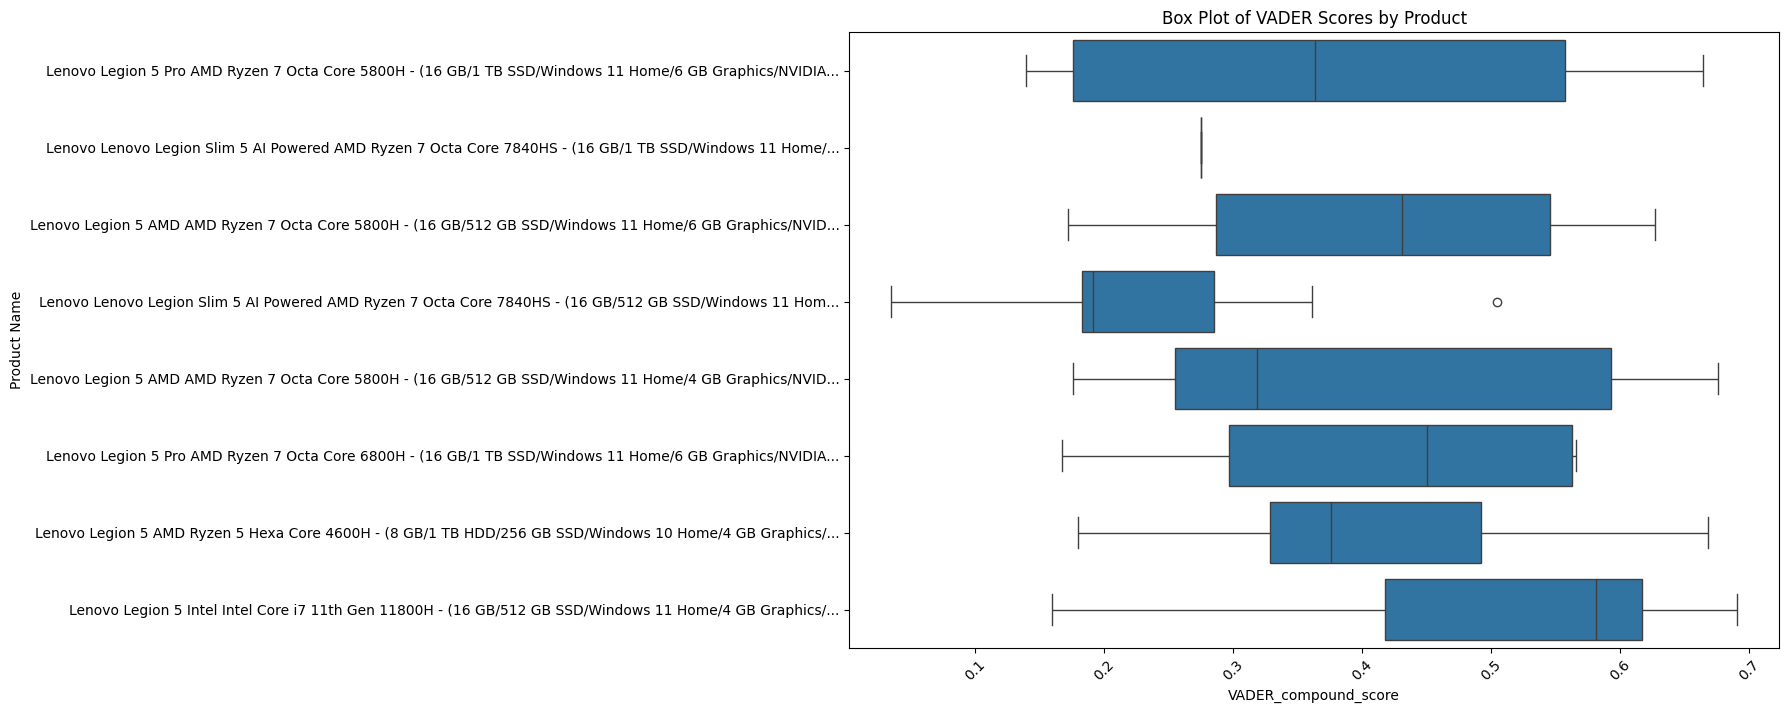

In [12]:
#Box Plot of VADER compound scores
plt.figure(figsize=(12, 8))  
sns.boxplot(x='VADER_compound_score', y='Product Name', data=df)  
plt.title('Box Plot of VADER Scores by Product')
plt.xticks(rotation=45)
plt.show()

## ROBERTA Sentiment Analysis

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [14]:
from transformers import RobertaConfig, RobertaModel

In [15]:
#Loading the RoBERTa model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
print(df['Review Details'][1])
sia.polarity_scores(df['Review Details'][1])

Nice beast


{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

In [17]:
print(df['Review Details'][1])
encoded_text = tokenizer(df['Review Details'][1], return_tensors='pt')             
output = model(**encoded_text)                                                     
scores = output[0][0].detach().numpy()                                             
scores = softmax(scores)
print(scores)

Nice beast
[0.02114491 0.12310262 0.8557525 ]


In [18]:
encoded_text = tokenizer("The laptop is really good and has a lot of cool and latest features", return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
print(scores)

[0.0026524  0.01006426 0.98728335]


In [19]:
def calculate_roberta_score(text):
    encoded_text = tokenizer(text, return_tensors='pt')                             #Tokenization
    output = model(**encoded_text)                                                  #model input
    scores = output[0][0].detach().numpy()                                          #post processing
    scores = softmax(scores)

    negative_score = scores[0]
    neutral_score = scores[1]
    positive_score = scores[2]
    
    # Calculating compound score based on negative, neutral and positive scores
    compound_score = (negative_score * -1) + (neutral_score * 0) + (positive_score * 1)

    scores_dict = {
        "neg" : scores[0],
        "neu" : scores[1],
        "pos" : scores[2],
        "compound" : compound_score
    }
    # print(scores_dict)
    
    return scores_dict

In [20]:
#Run the roBERTa model on the entire dataset and create columns for it
df[['RoBERTa_neg','RoBERTa_neu','RoBERTa_pos','RoBERTa_compound_Score']] = df.apply(calculate_weighted_score, args=(calculate_roberta_score,), axis = 1,result_type='expand')

In [21]:
df.head()

,Product Name,Price,Rating,Number of Ratings,Number of Reviews,Review Summary,Review Details,VADER_neg,VADER_neu,VADER_pos,VADER_compound_score,RoBERTa_neg,RoBERTa_neu,RoBERTa_pos,RoBERTa_compound_Score
0,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Mind-blowing purchase,Absolute gem,0.0000,0.8000,0.0000,0.17600,0.040945,0.130096,0.628959,0.764013
1,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Wonderful,Nice beast,0.0000,0.1315,0.6685,0.55832,0.014185,0.078027,0.707788,0.869604
2,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Awesome,"One word, Beast! But don't except much on batt...",0.0000,0.5000,0.3000,0.36347,0.091079,0.311075,0.397846,0.482767
3,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Delightful,Awesome Laptop,0.0000,0.0980,0.7020,0.66422,0.004814,0.026584,0.768602,0.939787
4,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Absolute rubbish!,1 star rating is for Flipkart's smart upgrade ...,0.0485,0.7055,0.0460,0.14015,0.656822,0.118396,0.024782,-0.456041


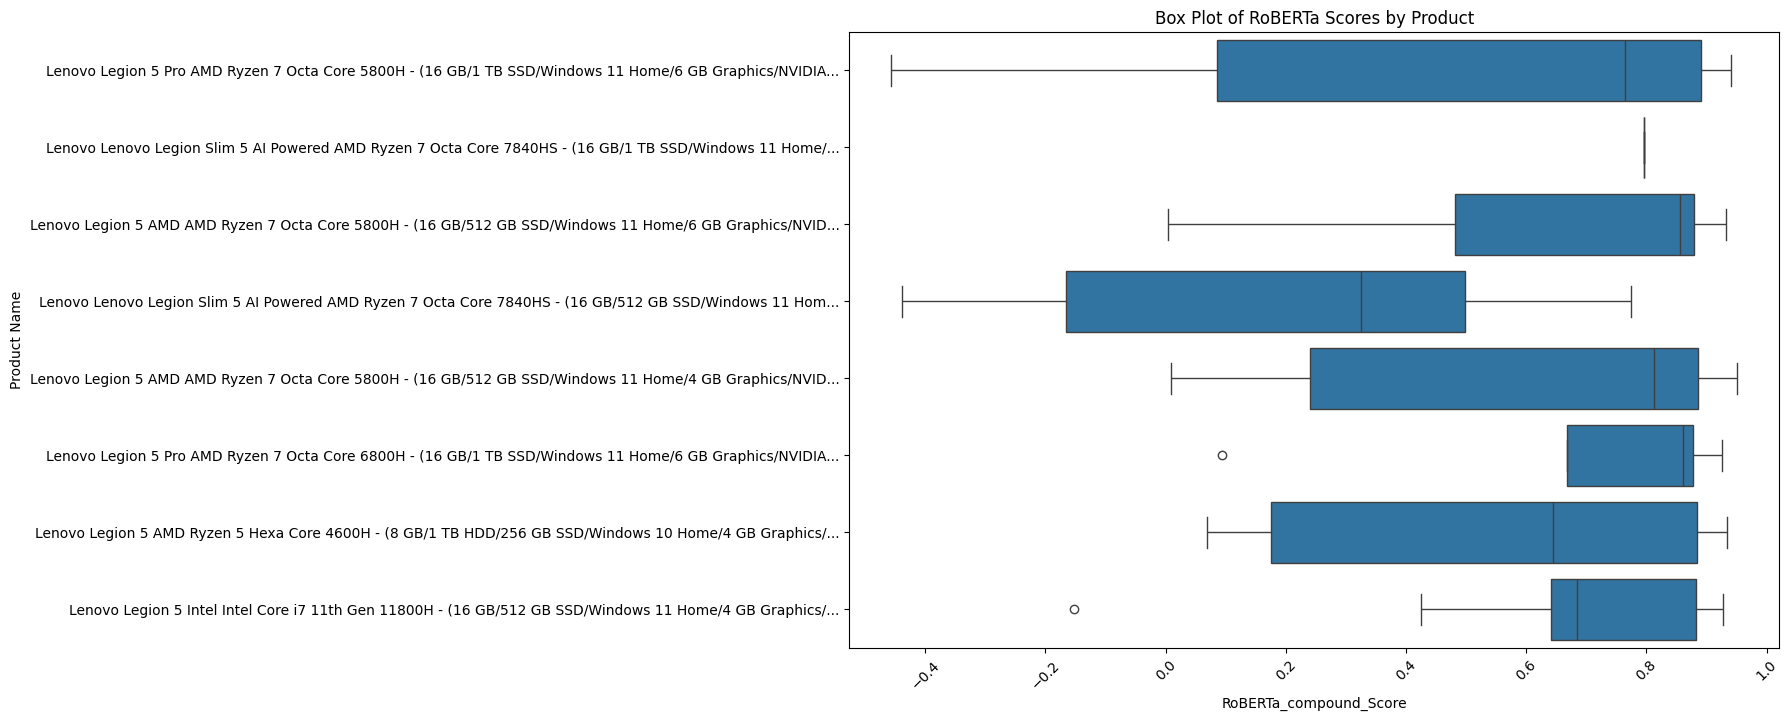

In [22]:
#Box Plot of RoBERTa compound scores
plt.figure(figsize=(12, 8))
sns.boxplot(x='RoBERTa_compound_Score', y='Product Name', data=df)
plt.title('Box Plot of RoBERTa Scores by Product')
plt.xticks(rotation=45)
plt.show()

In [23]:
df.columns

Index(['Product Name', 'Price', 'Rating', 'Number of Ratings',
       'Number of Reviews', 'Review Summary', 'Review Details', 'VADER_neg',
       'VADER_neu', 'VADER_pos', 'VADER_compound_score', 'RoBERTa_neg',
       'RoBERTa_neu', 'RoBERTa_pos', 'RoBERTa_compound_Score'],
      dtype='object')

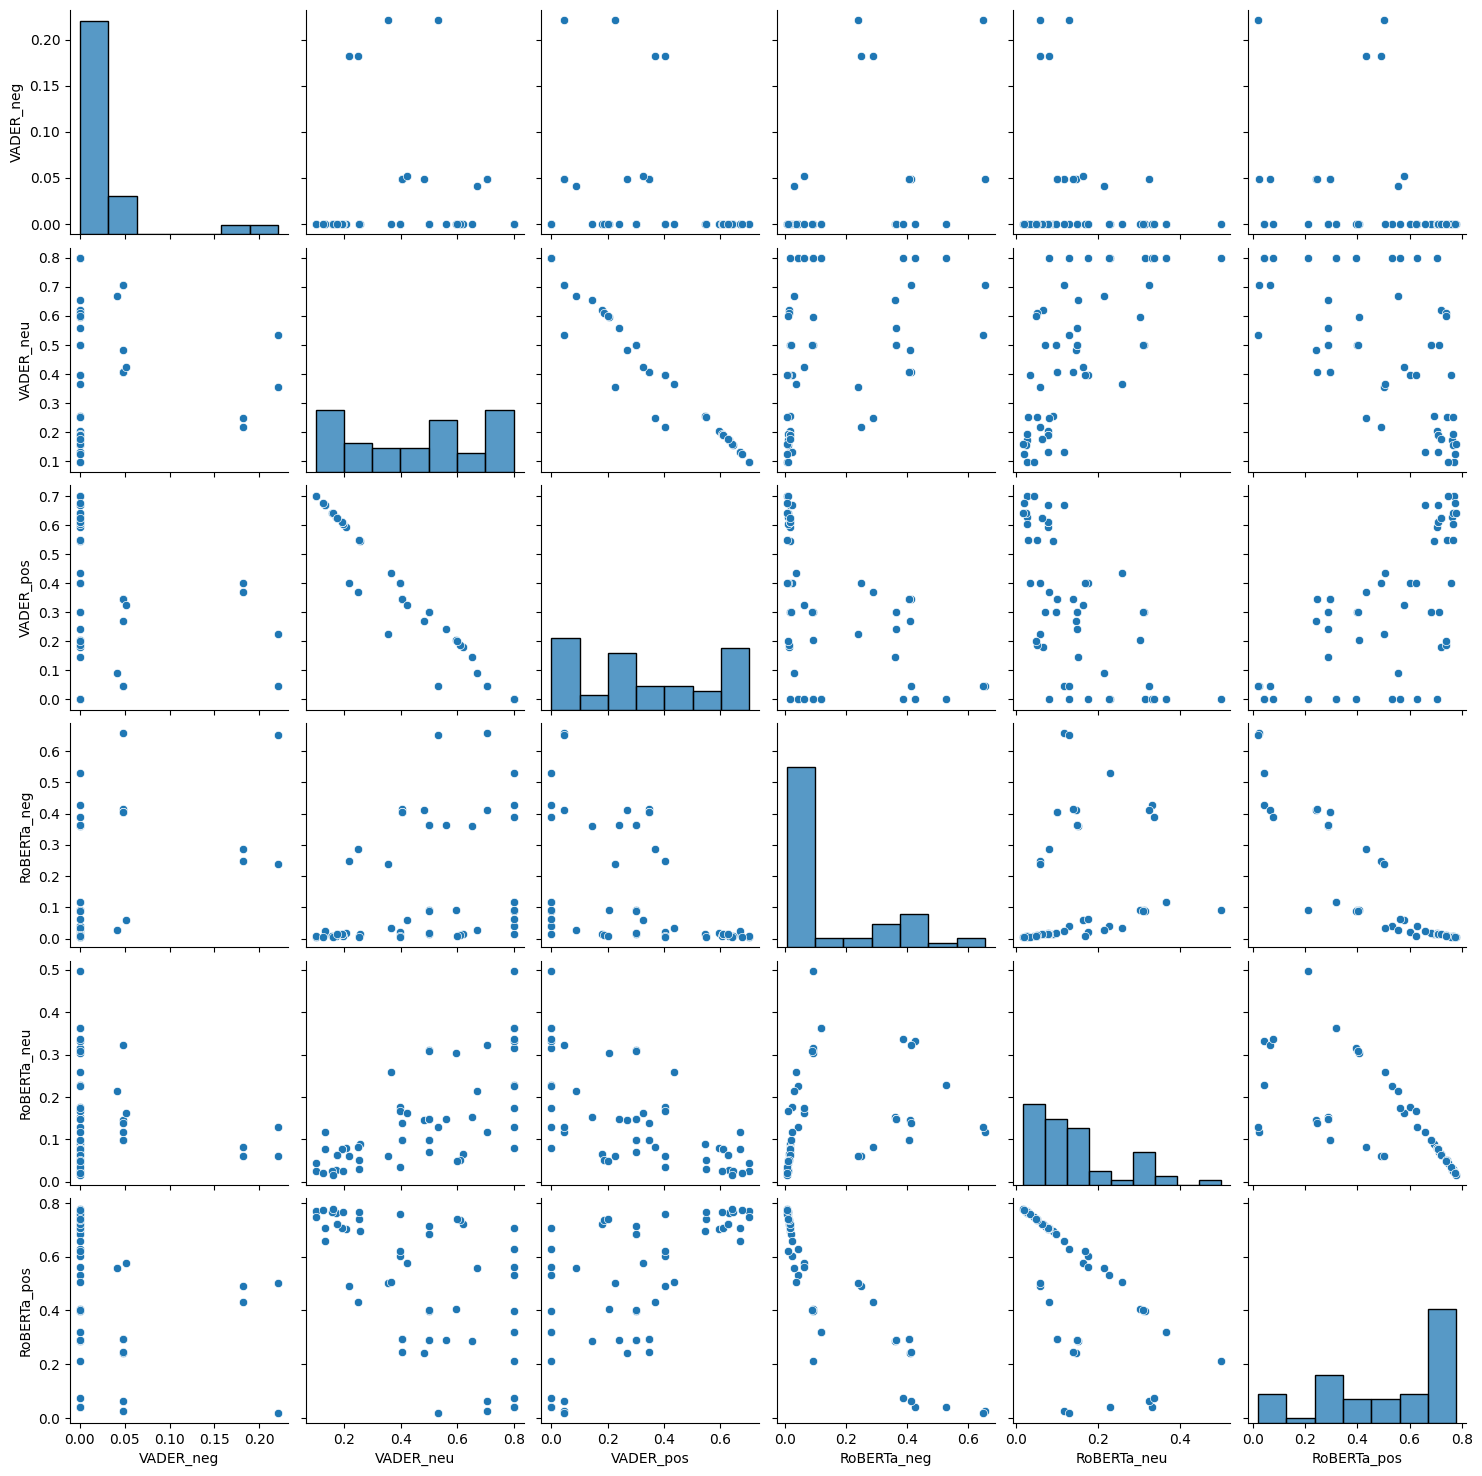

In [24]:
#Correlation analyses on VADER and RoBERTa scores
sns.pairplot(data=df,
             vars=['VADER_neg','VADER_neu', 'VADER_pos',
                  'RoBERTa_neg','RoBERTa_neu', 'RoBERTa_pos'])

In [30]:
#agrregating scores by grouping reviews for each product
aggregate_scores = df.groupby('Product Name').agg({
    'VADER_compound_score': 'mean',  # or any other aggregation method
    'RoBERTa_compound_Score': 'mean'
})

In [31]:
aggregate_scores

,VADER_compound_score,RoBERTa_compound_Score
Product Name,,
Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVID...,0.409499,0.575162
Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800H - (16 GB/512 GB SSD/Windows 11 Home/6 GB Graphics/NVID...,0.422131,0.639361
Lenovo Legion 5 AMD Ryzen 5 Hexa Core 4600H - (8 GB/1 TB HDD/256 GB SSD/Windows 10 Home/4 GB Graphics/...,0.416133,0.552864
Lenovo Legion 5 Intel Intel Core i7 11th Gen 11800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/...,0.493884,0.650917
Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800H - (16 GB/1 TB SSD/Windows 11 Home/6 GB Graphics/NVIDIA...,0.376357,0.456947
Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 6800H - (16 GB/1 TB SSD/Windows 11 Home/6 GB Graphics/NVIDIA...,0.408855,0.685114
Lenovo Lenovo Legion Slim 5 AI Powered AMD Ryzen 7 Octa Core 7840HS - (16 GB/1 TB SSD/Windows 11 Home/...,0.275010,0.795951
Lenovo Lenovo Legion Slim 5 AI Powered AMD Ryzen 7 Octa Core 7840HS - (16 GB/512 GB SSD/Windows 11 Hom...,0.236670,0.219072


In [32]:
#Avergae score for each product based on both model results
aggregate_scores['Combined_Score'] = aggregate_scores.mean(axis=1)

In [33]:
aggregate_scores

,VADER_compound_score,RoBERTa_compound_Score,Combined_Score
Product Name,,,
Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVID...,0.409499,0.575162,0.492330
Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800H - (16 GB/512 GB SSD/Windows 11 Home/6 GB Graphics/NVID...,0.422131,0.639361,0.530746
Lenovo Legion 5 AMD Ryzen 5 Hexa Core 4600H - (8 GB/1 TB HDD/256 GB SSD/Windows 10 Home/4 GB Graphics/...,0.416133,0.552864,0.484499
Lenovo Legion 5 Intel Intel Core i7 11th Gen 11800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/...,0.493884,0.650917,0.572400
Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800H - (16 GB/1 TB SSD/Windows 11 Home/6 GB Graphics/NVIDIA...,0.376357,0.456947,0.416652
Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 6800H - (16 GB/1 TB SSD/Windows 11 Home/6 GB Graphics/NVIDIA...,0.408855,0.685114,0.546985
Lenovo Lenovo Legion Slim 5 AI Powered AMD Ryzen 7 Octa Core 7840HS - (16 GB/1 TB SSD/Windows 11 Home/...,0.275010,0.795951,0.535480
Lenovo Lenovo Legion Slim 5 AI Powered AMD Ryzen 7 Octa Core 7840HS - (16 GB/512 GB SSD/Windows 11 Hom...,0.236670,0.219072,0.227871


In [34]:
#Finding the BEST PRODUCT
best_product = aggregate_scores['Combined_Score'].idxmax()
print("Product with the highest combined score:" ,best_product)

Product with the highest combined score: Lenovo Legion 5 Intel Intel Core i7 11th Gen 11800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/...


## RESULT 
# Lenovo Legion 5 Intel Intel Core i7 11th Gen 11800H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/...